# SNR (optimal) generation and comparison 

This notebook is a full guide on how to use the `gwsnr` package to generate the 'optimal signal-to-noise ratio' (SNR) and 'probability of detection' (Pdet) for a given Gravitational Wave (GW) signal.

## Contents

1. Introduction to `gwsnr` package
   
2. SNR with bilby inner product
   
3. Interpolation with Partial Scaling method
  
    * Testing speed and accurarcy between the interpolation method and inner product method
    * Pdet calculation
    * Changing the input arguments
   
4. SNR and Pdet with Artificial Neural Network ANN

5. Inner product assisted with JAX 

## I. Introduction to `gwsnr` package

`gwsnr` is a Python package for calculating the signal-to-noise ratio (SNR) of GW signals. It is designed for detecting GWs from compact binary coalescences (CBCs) with ground-based interferometers. This flexible and user-friendly tool allows users to mix and match different noise models, waveform models, detector configurations, and signal parameters. SNR calculations are enhanced through interpolation techniques and parallel processing.

By default, `gwsnr` uses the interpolation method. The example below generates the SNR for a GW signal from a spin-less binary black hole (BBH) merger with the following parameters: primary mass $m_1 = 30 M_\odot$, secondary mass $m_2 = 30 M_\odot$, and luminosity distance $d_L = 1000 \text{ Mpc}$; while the other parameters are set to their default values.

In [ ]:
# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR
import numpy as np

# initializing the GWSNR class with default parameters
gwsnr = GWSNR(snr_type='interpolation_no_spins')

# signal-to-noise ratio for a binary black hole merger with masses 10, 10 Msun at a luminosity distance of 100 Mpc
snrs = gwsnr.snr(mass_1=np.array([30.0]), mass_2=np.array([30.0]), luminosity_distance=np.array([1000.0]))

# print the signal-to-noise ratio
print('Computed SNRs:\n', snrs)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation_no_spins
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/

* Results have SNR values of the individual detector and the combined effective SNR value.

In [2]:
gwsnr.compute_bilby_snr(mass_1=np.array([30.0]), mass_2=np.array([30.0]), luminosity_distance=np.array([1000.0]))

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


{'L1': array([29.26371917]),
 'H1': array([18.61266212]),
 'V1': array([8.91382255]),
 'optimal_snr_net': array([35.80855601])}

In [ ]:
### Below shows GWSNR initialization with all of it's (default) arguments

```python
    gwsnr = GWSNR(
        #################################
        # General settings
        npool=4,  # number of processes. Run this to check the number of cores in your machine; import os; os.cpu_count()
        snr_type='interpolation',  # type of SNR calculation. Options are 'interpolation', 'inner_product', 'ann', 'inner_product_jax'
        interpolator_dir='./interpolator_pickle',  # directory to save/load the interpolator
        create_new_interpolator=False,  # if True, it will overwrite the existing interpolator
        gwsnr_verbose=True,  # if True, it will print all gwsnr settings
        multiprocessing_verbose=True, # if True, it will show progress bar for multiprocessing. If False, there will be no progress bar but it will be faster.
        pdet=False,  # if True, it will calculate the probability of detection
        snr_th=8.0,  # threshold SNR for the Pdet for each detector
        snr_th_net=8.0,  # threshold SNR for the Pdet for the network
        ann_path_dict=None,  # path to the ANN model for SNR and Pdet calculation
        #################################
        # Interpolation settings
        # Minimum and maximum values of the parameters for the interpolation grid
        # It is recommended to set minimum and maximum values a bit larger than the expected values to avoid edge effects
        mtot_min=2.0,  # minimum total mass in solar masses
        mtot_max=439.6,  # maximum total mass in solar masses (set to so that there is non zero inspiral length for the waveform)
        ratio_min=0.1,  # minimum mass ratio
        ratio_max=1.0,  # maximum mass ratio
        spin_max=0.9,  # maximum spin magnitude
        # Resolutions of the grid
        # Higher resolution means more accurate results but slower calculations
        mtot_resolution=200,  
        ratio_resolution=50,  
        spin_resolution=20,  # will be used only if snr_type is 'interpolation_aligned_spins'
        #################################
        # Waveform settings
        waveform_approximant='IMRPhenomD',  # frequency domain waveform approximant of the GW signal
        sampling_frequency=2048.0,  # sampling frequency in Hz
        minimum_frequency=20.0,  # minimum frequency of the waveform in Hz
        duration_max=None,  # maximum duration of the waveform in seconds. Bilby default for IMRPhenomXPHM is 64 seconds.
        duration_min=None,  # minimum duration of the waveform in seconds. Bilby default is 4 seconds.
        mtot_cut=True,  # if True, SNR=0 for total mass > mtot_cut
        #################################
        # Detector settings
        psds={'L1':'aLIGO_O4_high_asd.txt','H1':'aLIGO_O4_high_asd.txt', 'V1':'AdV_asd.txt', 'K1':'KAGRA_design_asd.txt'}, # power spectral density of the detectors
        ifos=['L1', 'H1', 'V1'],  # list of detectors. You can also provide bilby interferometer objects.
    )  
```

## II. Noise-Weighted Inner Product Method

The `gwsnr` package implements the standard noise-weighted inner product method to compute the signal-to-noise ratio (SNR), a core technique in gravitational-wave data analysis. This method is particularly suitable for frequency-domain waveforms generated by the `lalsimulation` library [@lalsuite], including models that incorporate spin precession and subdominant harmonic modes.

To enhance computational performance, `gwsnr` parallelizes waveform generation across multiple CPU cores and uses `numba`'s Just-In-Time (`njit`) compilation to accelerate antenna response functions, chirptime (signal duration) calculation, and inner product calculations. Additionally, the package offers optional support for JAX-based acceleration through the `ripple` waveform library [@Edwards:2023sak], using `jax.jit` for compilation and `jax.vmap` for batched operations.

### Mathematical Formulation

Following [@Allen:2012](https://arxiv.org/pdf/gr-qc/0509116), the noise-weighted inner product between two complex-valued frequency-domain waveforms, $\tilde{a}(f)$ and $\tilde{b}(f)$, defined as:

\begin{align}
\left< a | b \right> = 4 \int_{f_{\min}}^{f_{\max}} \frac{\tilde{a}(f), \tilde{b}^*(f)}{S_n(f)} , df \tag{1}
\end{align}

Here, $S_n(f)$ denotes the one-sided power spectral density (PSD) of the detector noise, and $[f_{\min}, f_{\max}]$ is the analysis frequency band.

GW waveform can be expressed as a combination of plus and cross polarizations, $\tilde{h}(f) = \tilde{h}_+(f) + i\, \tilde{h}_\times(f)$. Using this, we can write optimal SNR as:

\begin{align}
\rho = \sqrt{ \left< h | h \right> } = \sqrt{ 4 \int_{f_{\min}}^{f_{\max}} \frac{\tilde{h}(f)\, \tilde{h}^*(f)}{S_n(f)} \, df } \tag{2}
\end{align}

Assuming that $\tilde{h}+$ and $\tilde{h}\times$ are orthogonal, which is a good approximation for most waveform models including precessing cases, the SNR can be written in terms of detector response functions:

$$
\rho = \sqrt{ F_+^2 \left< \tilde{h}_+ | \tilde{h}_+ \right> + F_\times^2 \left< \tilde{h}_\times | \tilde{h}_\times \right> } \tag{3}
$$

The antenna pattern functions $F_+$ and $F_\times$ depend on the detector's orientation and the source's sky location ($\alpha$, $\delta$), inclination ($\iota$), polarization angle ($\psi$), and geocentric time ($t_c$). The waveform polarizations $\tilde{h}_{+,\times}$ themselves depend on both intrinsic parameters (component masses $m_1$, $m_2$, and spins) and extrinsic parameters (luminosity distance $D_L$, inclination angle $\iota$, coalescence phase $\phi_c$, and $t_c$).

This method offers a flexible and robust framework for computing optimal matched-filter SNRs using arbitrary waveform models and detector configurations. Its performance-optimized implementation makes it suitable for a wide range of use cases, including population synthesis studies, injection campaigns, and parameter inference pipelines.


In [2]:
# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR

# initializing the GWSNR class with inner product as the signal-to-noise ratio type
gwsnr = GWSNR(snr_type='inner_product', waveform_approximant='IMRPhenomXPHM')

# signal-to-noise ratio for a BBH with GW150914 like parameters with detectors LIGO-Hanford, LIGO-Livingston, and Virgo with O4 observing run sensitivity
snrs = gwsnr.snr(
    mass_1=np.array([36.0]), # mass of the primary black hole in solar masses
    mass_2=np.array([29.0]), # mass of the secondary black hole in solar masses
    luminosity_distance=np.array([440.0]), # luminosity distance in Mpc
    theta_jn=np.array([1.0]), # inclination angle in radians
    ra=np.array([3.435]), # right ascension in radians
    dec=np.array([-0.408]), # declination in radians
    psi=np.array([0.0]),  # polarization angle in radians
    geocent_time=np.array([1126259462.4]), # geocentric time in GPS seconds
    a_1=np.array([0.3]), # dimensionless spin of the primary black hole
    a_2=np.array([0.2]), # dimensionless spin of the secondary black hole
    tilt_1=np.array([0.5]), # tilt angle of the primary black hole in radians
    tilt_2=np.array([0.8]), # tilt angle of the secondary black hole in radians
    phi_12=np.array([0.0]), # Relative angle between the primary and secondary spin of the binary in radians
    phi_jl=np.array([0.0]), # Angle between the total angular momentum and the orbital angular momentum in radians
)
print('\nComputed SNRs with inner product:\n', snrs)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)

Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phura

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


Computed SNRs with inner product:
 {'L1': array([46.5492244]), 'H1': array([48.22499937]), 'V1': array([13.20876067]), 'optimal_snr_net': array([68.31509507])}


### III. The Partial Scaling Interpolation Method

The `gwsnr` package implements the Partial Scaling method, an interpolation-assisted technique designed for the rapid calculation of SNR of binary systems with non-spinning or aligned-spin components. Although originally conceived for simple inspiral-only waveforms, the method has since been generalized to include full inspiral-merger-ringdown (IMR; frequency domain) waveforms available in the `lalsimulation` library. 

The core principle, adapted from the FINDCHIRP algorithm ([@Allen:2012](https://arxiv.org/pdf/gr-qc/0509116)), is to pre-compute and interpolate the most computationally expensive component of the SNR calculation—termed the "partial SNR," denoted as $\rho_{1/2}$. This partial SNR depends solely on the intrinsic parameters of the binary, such as total mass $M$, mass ratio $q$, and spin magnitudes $a_1$ and $a_2$. The final SNR is then quickly recovered through the application of a simple scaling factor. To further optimize performance, the entire procedure, including both antenna response computations and interpolation, is accelerated using `JAX`'s just-in-time (`jax.jit`) compilation and parralelized using `jax.vmap`.

### Mathematical Formulation

The Partial Scaling method begins with the standard definition of the optimal SNR, $\rho$. For a simple inspiral waveform, following Eq.(2) of the Sec.([II](#ii-noise-weighted-inner-product-method)) and Eq.(D1) of [@Allen:2012](https://arxiv.org/pdf/gr-qc/0509116), the SNR can be written as
$$
\begin{align}
\rho &= \sqrt{4 \int_{f_{\rm min}}^{f_{\rm max}} \frac{|\tilde{h}(f)|^2}{S_n(f)}\, df}, \notag \\
&= \left( \frac{1~\mathrm{Mpc}}{D_{\mathrm{eff}}} \right)
\sqrt{4 \mathcal{A}_{1~\mathrm{Mpc}}^2 ({\cal M})
\int_{f_{\rm min}}^{f_{\rm max}} \frac{f^{-7/3}}{S_n(f)}\, df }, \notag \\
&= \left(\frac{1~\mathrm{Mpc}}{D_{\mathrm{eff}}}\right) \mathcal{A}_{1~\mathrm{Mpc}} ({\cal M}) \sqrt{ 4\int_{f_{\rm min}}^{f_{\rm lso}} \frac{f^{-7/3}}{S_n(f)}df }, \tag{B1}
\end{align}
$$
where $\tilde{h}(f)$ is the frequency-domain waveform, $S_n(f)$ is the detector noise power spectral density, and $D_{\text{eff}}$ is the effective distance to the source. The amplitude term, $\mathcal{A}_{1,\text{Mpc}}$, is a function of the chirp mass ${\cal M}$. Now, $D_{\text{eff}}$ and $\mathcal{A}_{1,\text{Mpc}}$ reads
$$
\begin{align}
\mathcal{A}_{\rm 1Mpc} &= \left(\frac{5}{24\pi}\right)^{1/2}
\left(\frac{GM_\odot/c^2}{1~\mathrm{Mpc}}\right)
\left(\frac{\pi GM_\odot}{c^3}\right)^{-1/6}
\left(\frac{\mathcal{M}}{M_\odot}\right)^{5/6} \,,\tag{B2} \\
D_\mathrm{eff} &= D_l \left[
    F_+^2 \left(\frac{1+\cos^2\iota}{2}\right)^2 +
    F_\times^2 \cos^2\iota
\right]^{-1/2}\tag{B3} \\
\end{align}
$$

$\mathcal{M}$ is the chirp mass, and in terms of ($M,q$) it reads $\mathcal{M} = M \left( \frac{q}{1+q^2} \right)^{3/5}$, where $M = m_1 + m_2$ is the total mass and $q = m_2/m_1$ is the mass ratio. 
$D_l$ is the luminosity distance, $\iota$ is the inclination angle, and $F_+$ and $F_\times$ are the antenna patterns of the detector.
The integral runs from a minimum frequency $f_{\min}$ (typically $20$ Hz) up to the frequency of the last stable orbit, which is determined by the total mass of the binary system as $f_{\rm LSO} = 1/(6^{3/2} \pi) (G\,M/c^3)^{-1/2}$.

A key insight is to isolate the computationally intensive integral, which is independent of extrinsic parameters such as distance and sky location. This term is defined as the partial-SNR, $\rho_{1/2}$ and it reads
$$
\begin{align}
\rho_{1/2} &= \left(\frac{D_\mathrm{eff}}{1~\mathrm{Mpc}}\right) \mathcal{M}^{-5/6} \times \rho\,, \tag{B4}\\
&= \left(\frac{5}{24\pi}\right)^{1/2}
\left(\frac{GM_\odot/c^2}{1~\mathrm{Mpc}}\right)
\left(\frac{\pi GM_\odot}{c^3}\right)^{-1/6}
\left(\frac{1}{M_\odot}\right)^{5/6}
\sqrt{4 \int_{20}^{f_{\rm LSO}} \frac{f^{-7/3}}{S_n(f)}\, df} \tag{B5}
\end{align}
$$

For more general IMR waveforms the same principle applies. The full SNR, $\rho_{\text{bilby}}$, is first calculated using a library such as `bilby`, and the partial SNR is analogously defined as
$$
\begin{align}
\rho_{1/2} &= \left(\frac{D_\mathrm{eff}}{1~\mathrm{Mpc}}\right) \mathcal{M}^{-5/6} \times \rho_{\rm bilby}\,, \tag{B6}
\end{align}
$$

### Interpolation Procedure

To obtain the SNR for a new set of binary parameters, the method interpolates $\rho_{1/2}$ from a pre-computed grid. For non-spinning IMR waveforms, a two-dimensional grid in $(M, q)$ is constructed, with grid spacing optimized to minimize interpolation error: the $q$ axis is logarithmically spaced, while the $M$ axis is inverse-logarithmically spaced. Given a new parameter set $(M_{\text{new}}, q_{\text{new}})$, **nested one-dimensional cubic spline interpolation** (see Sec.([IV](#iv-nested-1d-cubic-spline-interpolation))) is used to determine the corresponding value of $\rho_{1/2}$ from the pre-computed grid. These $\rho_{1/2}$ values are stored in a pickle file for efficient future access.

For spin-aligned IMR waveforms, the approach is extended to a four-dimensional grid spanning $(M, q, a_1, a_2)$, where $a_1$ and $a_2$ are the dimensionless spin magnitudes. The $(M, q)$ axes maintain the optimized spacing, while the spin axes are uniformly spaced within a user-defined range.

Once the interpolated value of $\rho_{1/2}$ is obtained, the final optimal SNR is simply recovered by scaling with the chirp mass and effective distance:
$$
\begin{align}
\rho = \rho_{1/2} \times \left( \frac{D_{\text{eff}}}{1~\mathrm{Mpc}} \right) \left( \frac{{\cal M}}{M_\odot} \right)^{5/6}.
\end{align}
$$
This methodology enables rapid and accurate SNR evaluation across the full parameter space relevant to gravitational wave detection.

## IV. Nested 1D Cubic Spline Interpolation

The Partial Scaling method relies on nested one-dimensional (1D) cubic spline interpolation to efficiently estimate the partial SNR, $\rho_{1/2}$, for a new set of binary parameters. This hierarchical approach avoids the complexity of multi-dimensional spline fitting by applying a sequence of 1D interpolations across each parameter dimension.

### Interpolation for Non-Spinning Systems

To illustrate the process, consider the 2D case for a non-spinning system with a pre-computed grid of $\rho_{1/2}$ values over $M$ $q$ parameter space. The interpolation proceeds in several key steps. First, the axis arrays for $M$ and $q$ are obtained, and the precomputed $\rho_{1/2}$ values are loaded from a pickle file. These $\rho_{1/2}$ values are defined for each $(M, q)$ pair on the grid.

Given a new set of binary parameters $(M_{\rm new}, q_{\rm new})$, the next step is to identify the four nearest neighboring points along each axis: for $M$, the points $[M_{i-1}, M_i, M_{i+1}, M_{i+2}]$ are selected such that $M_i \leq M_{\rm new} \leq M_{i+1}$; similarly, for $q$, the points $[q_{j-1}, q_j, q_{j+1}, q_{j+2}]$ are chosen so that $q_j \leq q_{\rm new} \leq q_{j+1}$.

For each fixed value of $q$, a one-dimensional cubic spline interpolation is performed along the $M$ axis to estimate the value of $\rho_{1/2}$ at $M_{\rm new}$. This process yields a set of four intermediate values, corresponding to $q_{j-1}$, $q_j$, $q_{j+1}$, and $q_{j+2}$:
$$
\left[ \rho_{1/2}(q_{j-1}, M_{\rm new}),\, \rho_{1/2}(q_j, M_{\rm new}),\, \rho_{1/2}(q_{j+1}, M_{\rm new}),\, \rho_{1/2}(q_{j+2}, M_{\rm new}) \right].
$$
A subsequent cubic spline interpolation is then carried out along the $q$ axis, using these values, to determine the final interpolated result $\rho_{1/2}(M_{\rm new}, q_{\rm new})$.

<img src="grid2D.jpg" alt="2D Grid Interpolation" width="400"/>

For the spin-aligned IMR waveform, the methodology is conceptually identical but operates in a four-dimensional grid spanning $(M, q, a_1, a_2)$, where $a_1$ and $a_2$ are the dimensionless spin parameters. The interpolation follows a hierarchical scheme, beginning with the $a_1$ and $a_2$ axes, followed by $M$, and finally $q$, recursively applying the one-dimensional cubic spline interpolation at each stage until the final value, $\rho_{1/2}(M_{\rm new}, q_{\rm new}, a_{1, \rm new}, a_{2, \rm new})$, is obtained.

When dealing with edge cases—specifically, when the target value lies near or outside the bounds of the precomputed grid—a straightforward approach is adopted: the nearest available $\rho_{1/2}$ value is used. For example, if $M_{\rm new} < M_0$ or $M_{\rm new} < (M_1 - M_0)/2$, where $M_0$ and $M_1$ are the first and second entries of the $M$ axis, the interpolated value is set to $\rho_{1/2}(M_0, q_{\rm new})$. This ensures stability and consistency of the interpolation even at or beyond the boundaries of the parameter space.

## Interpolation for Non Spinning Systems

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

In [ ]:
# initializing the GWSNR class with default configuration and interpolation method
# for non-spinning IMRPhenomD waveform 
gwsnr_no_spins = GWSNR(
    npool=8,
    snr_type='interpolation', # or 'interpolation_no_spins'
    gwsnr_verbose=False,
)

mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
dl = 1000
print('Interpolation results: ')
print(gwsnr_no_spins.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))
print('\n Inner product results: ')
print(gwsnr_no_spins.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle


Interpolation results: 
{'L1': array([ 7.40696338, 11.59593758, 31.03604209, 26.59899205]), 'H1': array([ 4.71106581,  7.37538749, 19.73991624, 16.91781038]), 'V1': array([2.22225701, 3.44038484, 9.3348564 , 7.86143156]), 'optimal_snr_net': array([ 9.05514626, 14.16680475, 37.94785562, 32.48877948])}

 Inner product results: 


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.17it/s]

{'L1': array([ 7.40709512, 11.59602211, 31.03567109, 26.59869097]), 'H1': array([ 4.7111496 ,  7.37544125, 19.73968027, 16.91761888]), 'V1': array([2.22230853, 3.44041035, 9.33473625, 7.86132463]), 'optimal_snr_net': array([ 9.05531026, 14.16690812, 37.94739989, 32.48840739])}


### Testing speed and accuracy between the interpolation method and inner product method.

* set up the BBH Binary-Black-Holes parameters
* simulate 10000 events

In [2]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 10000
chirp_mass = np.linspace(5,60,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5),
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(0,np.pi, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
)

In [4]:
# for non-spinning IMRPhenomD waveform 
# running it for the first time will take longer, as the jit code generate the compiled code
start_time = datetime.now()
interp_snr_no_spins = gwsnr_no_spins.snr(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration interpolation: {}'.format(end_time - start_time))

Duration interpolation: 0:00:00.081497


In [5]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_snr = gwsnr_no_spins.compute_bilby_snr(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration inner-product: {}'.format(end_time - start_time))

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████| 9991/9991 [00:05<00:00, 1697.48it/s]


Duration inner-product: 0:00:06.901390


* interpolation method is much faster than inner product method

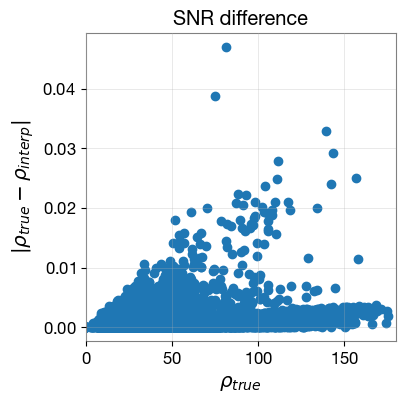

In [16]:
plt.figure(figsize=(4,4))
plt.plot(bilby_snr['optimal_snr_net'], abs(interp_snr_no_spins['optimal_snr_net']-bilby_snr['optimal_snr_net']), 'o', color='C0')
plt.xlabel(r"$\rho_{true}$")
plt.ylabel(r"$|\rho_{true} - \rho_{interp}|$")
plt.title(r"SNR difference")
plt.xlim(0, 180)
plt.grid(alpha=0.4)
plt.show()

In [10]:
print('Maximum relative % error in SNR:', max(abs(interp_snr_no_spins['optimal_snr_net']-bilby_snr['optimal_snr_net'])/ interp_snr_no_spins['optimal_snr_net'] * 100))


Maximum relative % error in SNR: 0.05770789996314418


/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_49147/2999260810.py:1: RuntimeWarning: invalid value encountered in divide
  print('Maximum relative % error in SNR:', max(abs(interp_snr_no_spins['optimal_snr_net']-bilby_snr['optimal_snr_net'])/ interp_snr_no_spins['optimal_snr_net'] * 100))


* the absolute difference between the SNR values from the interpolation method and the inner product method is $\lesssim 0.05$ for all events.

* The relative percentage error is $\lesssim 0.06\%$ for all events.

## Interpolation for align-spins Systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

In [3]:
# initializing the GWSNR class with default configuration and interpolation method
# for aligned-spinning IMRPhenomD waveform 
gwsnr_aligned_spins = GWSNR(
    npool=8,
    snr_type='interpolation_aligned_spins',
    gwsnr_verbose=False,
)

mass_1 = np.array([5, 10.,20.,30.])
ratio = np.array([1, 0.8,0.5,0.2])
a_1 = np.array([0.0, 0.2, 0.5, -0.7])
a_2 = np.array([0.0, -0.4, 0.5, 0.2])
dl = 1000* np.ones_like(mass_1)
print('Interpolation results: ')
print(gwsnr_aligned_spins.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl, a_1=a_1, a_2=a_2))
print('\n Inner product results: ')
print(gwsnr_aligned_spins.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl, a_1=a_1, a_2=a_2))


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle


Interpolation results: 
{'L1': array([ 7.40697428, 11.51038956, 17.425896  , 11.28660553]), 'H1': array([ 4.71107274,  7.32097621, 11.08342766,  7.1786424 ]), 'V1': array([2.22226236, 3.41240471, 5.1967416 , 3.28231288]), 'optimal_snr_net': array([ 9.0551601 , 14.06165945, 21.29578228, 13.77294264])}

 Inner product results: 


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.17it/s]

{'L1': array([ 7.40709512, 11.51048787, 17.42610539, 11.28839655]), 'H1': array([ 4.7111496 ,  7.32103874, 11.08356084,  7.17978155]), 'V1': array([2.22230853, 3.41242961, 5.19684919, 3.28232586]), 'optimal_snr_net': array([ 9.05531026, 14.06177852, 21.29604919, 13.77500719])}


In [4]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 10000
chirp_mass = np.linspace(5,60,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5),
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(0,np.pi, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    # spin zero
    a_1 = np.random.uniform(-0.8,0.8, size=nsamples),
    a_2 = np.random.uniform(-0.8,0.8, size=nsamples),
)

In [5]:
# for non-spinning IMRPhenomD waveform 
# running it for the first time will take longer, as the jit code generate the compiled code
start_time = datetime.now()
interp_snr_aligned_spins = gwsnr_aligned_spins.snr(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration interpolation: {}'.format(end_time - start_time))

Duration interpolation: 0:00:24.123116


In [6]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_snr = gwsnr_aligned_spins.compute_bilby_snr(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration inner-product: {}'.format(end_time - start_time))

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████| 9985/9985 [00:05<00:00, 1807.28it/s]

Duration inner-product: 0:00:05.713317


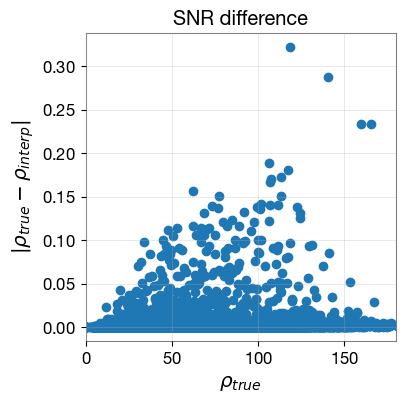

In [7]:
plt.figure(figsize=(4,4))
plt.plot(bilby_snr['optimal_snr_net'], abs(interp_snr_aligned_spins['optimal_snr_net']-bilby_snr['optimal_snr_net']), 'o', color='C0')
plt.xlabel(r"$\rho_{true}$")
plt.ylabel(r"$|\rho_{true} - \rho_{interp}|$")
plt.title(r"SNR difference")
plt.xlim(0, 180)
plt.grid(alpha=0.4)
plt.show()

In [9]:
print('Maximum relative % error in SNR:', max(abs(interp_snr_aligned_spins['optimal_snr_net']-bilby_snr['optimal_snr_net'])/ interp_snr_aligned_spins['optimal_snr_net'] * 100))

Maximum relative % error in SNR: 0.2937653006758557


/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_49919/3421496590.py:1: RuntimeWarning: invalid value encountered in divide
  print('Maximum relative % error in SNR:', max(abs(interp_snr_aligned_spins['optimal_snr_net']-bilby_snr['optimal_snr_net'])/ interp_snr_aligned_spins['optimal_snr_net'] * 100))


* the absolute difference between the SNR values from the interpolation method and the inner product method is $\lesssim 0.4$ for all events.

* The relative percentage error is $\lesssim 0.3\%$ for all events.

* Note that interpolation accuracy is higher for non-spinning systems than for aligned-spin systems, as expected.

## SNR recalculation

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

# initializing the GWSNR class with default configuration and interpolation method
# for aligned-spinning IMRPhenomD waveform 
gwsnr_aligned_spins = GWSNR(
    npool=8,
    snr_type='interpolation_aligned_spins_jax',
    gwsnr_verbose=False,
    snr_recalculation=True,  # Enable recalculation of SNRs
    snr_recalculation_range=[2,14],  # Range of optimal SNR for recalculation
    snr_recalculation_waveform_approximant='IMRPhenomXPHM',  # Waveform approximant for recalculation
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle




In [20]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 1000
chirp_mass = np.linspace(5,60,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5),
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5),
    # Fix luminosity distance
    luminosity_distance = np.random.uniform(100, 2000, size=nsamples),  # Random luminosity distance between 100 and 1000 Mpc
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples),
    dec = np.random.uniform(0,np.pi, size=nsamples),
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    # spin zero
    a_1 = np.random.uniform(0.0,0.8, size=nsamples),
    a_2 = np.random.uniform(0.0,0.8, size=nsamples),
    tilt_1 = np.random.uniform(0, np.pi, size=nsamples),  # tilt angle of the primary black hole in radians
    tilt_2 = np.random.uniform(0, np.pi, size=nsamples),
    phi_12 = np.random.uniform(0, 2*np.pi, size=nsamples),  # Relative angle between the primary and secondary spin of the binary in radians
    phi_jl = np.random.uniform(0, 2*np.pi, size=nsamples),  # Angle between the total angular momentum and the orbital angular momentum in radians
)

In [21]:
# with recalculation enabled, the SNR will be recalculated for the specified range
gwsnr_aligned_spins.waveform_approximant = 'IMRPhenomD'
interp_snr_aligned_spins = gwsnr_aligned_spins.snr(gw_param_dict=param_dict.copy())

solving SNR with interpolation
Recalculating SNR for 242 out of 1000 samples in the SNR range of 2 to 14


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 257.06it/s]


In [22]:
gwsnr_aligned_spins.waveform_approximant = 'IMRPhenomXPHM'
bilby_snr = gwsnr_aligned_spins.compute_bilby_snr(gw_param_dict=param_dict)
gwsnr_aligned_spins.waveform_approximant = 'IMRPhenomD'

100%|████████████████████████████████████████████████████████████| 999/999 [00:01<00:00, 700.74it/s]


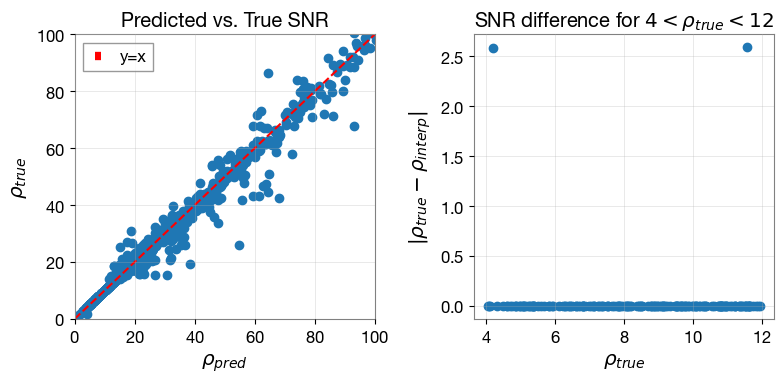

In [24]:
# compare the SNRs
plt.figure(figsize=(8,4))

# Left panel: rho_pred vs rho_true
plt.subplot(1, 2, 1)
plt.plot(bilby_snr['optimal_snr_net'], interp_snr_aligned_spins['optimal_snr_net'], 'o', color='C0')
# diagonal line
max_ = 100
min_ = 0
plt.plot([min_, max_], [min_, max_], 'r--', label='y=x')
plt.xlabel(r"$\rho_{pred}$")
plt.ylabel(r"$\rho_{true}$")
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(min_, max_)
plt.ylim(min_, max_)
plt.legend()
plt.title(r"Predicted vs. True SNR")
plt.grid(alpha=0.4)

# Right panel: SNR difference
plt.subplot(1, 2, 2)
idx = (bilby_snr['optimal_snr_net'] > 4) & (bilby_snr['optimal_snr_net'] < 12)
plt.plot(bilby_snr['optimal_snr_net'][idx], abs(interp_snr_aligned_spins['optimal_snr_net'][idx]-bilby_snr['optimal_snr_net'][idx]), 'o', color='C0')
plt.xlabel(r"$\rho_{true}$")
plt.ylabel(r"$|\rho_{true} - \rho_{interp}|$")
plt.title(r"SNR difference")
plt.grid(alpha=0.4)
plt.title(r"SNR difference for $4 < \rho_{true} < 12$")
plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

In [25]:
# chack accuracy for Pdet
pdet_pred = gwsnr_aligned_spins.probability_of_detection(snr_dict=interp_snr_aligned_spins, snr_th=8.0, snr_th_net=8.0, type='bool')
pdet_true = gwsnr_aligned_spins.probability_of_detection(snr_dict=bilby_snr, snr_th=8.0, snr_th_net=8.0, type='bool')

In [26]:
# accuracy of the probability of detection
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(pdet_true['pdet_net'], pdet_pred['pdet_net'])
print("Confusion Matrix:")
print(cm)

acc = accuracy_score(pdet_true['pdet_net'], pdet_pred['pdet_net'])
print("Accuracy:", acc)


Confusion Matrix:
[[ 91   0]
 [  0 909]]
Accuracy: 1.0


* This can be the most optimal way for calculating Pdet

## Probability of Detection Calculation

The `gwsnr` package provides tools to evaluate the probability of detecting a GW signal, denoted as $P_{\rm det}$. The calculation is based on whether the observed SNR exceeds a specified threshold, $\rho_{\rm th}$, for either individual detectors or a detector network. For most practical applications with Gaussian noise, using an SNR threshold is a reliable (proxy) criterion for detection.

`gwsnr` implements two primary approaches to compute $P_{\rm det}$: one based on the optimal SNR, $\rho_{\rm opt}$, and another using the matched-filter SNR, $\rho_{\rm mf}$.

### Detection Probability with Optimal SNR

When using the optimal SNR, the detection criterion is straightforward. A signal is considered detected if $\rho_{\rm opt}$ surpasses the threshold $\rho_{\rm th}$. In this case, the detection probability is represented as a step function:

$$
P_{\rm det} = P(\theta\mid \rho_{\rm opt}) =
\begin{cases}
1 & \text{if } \rho_{\rm opt} > \rho_{\rm th}, \\
0 & \text{otherwise},
\end{cases}
$$

where $\theta$ represents the set of parameters for the GW signal.

### Detection Probability with Matched-Filter SNR

For a more realistic scenario, the matched-filter SNR, $\rho_{\rm mf}$, fluctuates due to noise and follows a normal distribution with mean $\rho_{\rm opt}(\theta)$ and unit variance for a given set of parameters $\theta$. Following [Thrane et al. 2019](https://arxiv.org/abs/1809.02293), the probability density for measuring a particular value $\rho_{\rm mf}$ is

$$
p(\rho_{\rm mf} | \theta) = \frac{1}{\sqrt{2\pi}} \exp\left[-\frac{1}{2} \left( \rho_{\rm mf} - \rho_{\rm opt}(\theta) \right)^2 \right].
$$

The probability that the measured SNR exceeds the threshold, i.e., the probability of detection, is then given by

$$
P_{\rm det} = P(\theta\mid \rho_{\rm opt}) = \int_{\rho_{\rm th}}^{\infty} \frac{1}{\sqrt{2\pi}} \exp\left[ -\frac{1}{2} (x - \rho_{\rm opt}(\theta))^2 \right] dx.
$$

Numerically, the integral for the probability of detection can be evaluated using the cumulative distribution function (CDF) of the standard normal distribution. In practice, this is implemented in `gwsnr` as

```python
P_det = 1 - norm.cdf(snr_th - snr_opt)
```

**Note:** This way of calculating $\rho_{\rm mf}$ doesn't involve matched-filter SNR calculation, but rather uses the optimal SNR $\rho_{\rm opt}$, which is computed using the noise-weighted inner product method or the Partial Scaling method.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

gwsnr = GWSNR(
    npool=8,
    snr_type='interpolation_aligned_spins',
    gwsnr_verbose=False,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle




In [5]:
mass_1 = np.array([2,50.,100.,])
ratio = 0.9
dl = 500
snr_dict = gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl)
# optimal SNR based pdet
pdet_snr_ = gwsnr.probability_of_detection(snr_dict, snr_th=8, snr_th_net=8, type='bool')
print('Optimal SNR (network):', snr_dict["optimal_snr_net"])
print('Probability of detection (network) with snr_opt:', pdet_snr_["pdet_net"])
# matching SNR based pdet
pdet_snr_ = gwsnr.probability_of_detection(snr_dict, snr_th=8, snr_th_net=8, type='matched_filter')
print('Probability of detection (network) with snr_mf:', pdet_snr_["pdet_net"])

Optimal SNR (network): [  8.533422   100.91201099   0.        ]
Probability of detection (network) with snr_opt: [1 1 0]
Probability of detection (network) with snr_mf: [7.03129255e-01 1.00000000e+00 6.66133815e-16]


In [6]:
# Accuracy on classifing detectable events
from sklearn.metrics import confusion_matrix, accuracy_score

# Generate some example data
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 10000
chirp_mass = np.linspace(5,60,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5),
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(0,np.pi, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    # spin zero
    a_1 = np.random.uniform(-0.8,0.8, size=nsamples),
    a_2 = np.random.uniform(-0.8,0.8, size=nsamples),
)

In [7]:
# for aligned spins, interpolation method
# running it for the first time will take longer, as the jit code generate the compiled code
snr_pred = gwsnr.snr(gw_param_dict=param_dict)
# Compute the probability of detection
pdet_pred = gwsnr.probability_of_detection(snr_pred, snr_th=8, snr_th_net=8, type='bool')

# inner product method
snr_bilby = gwsnr.compute_bilby_snr(gw_param_dict=param_dict)
# Compute the probability of detection
pdet_true = gwsnr.probability_of_detection(snr_bilby, snr_th=8, snr_th_net=8, type='bool')

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████| 9983/9983 [00:06<00:00, 1609.32it/s]


In [ ]:
cm = confusion_matrix(pdet_true['pdet_net'], pdet_pred['pdet_net'])
print("Confusion Matrix:")
print(cm)

acc = accuracy_score(pdet_true['pdet_net'], pdet_pred['pdet_net'])
print("Accuracy:", acc)

Confusion Matrix:
[[ 120    0]
 [   1 9879]]
Accuracy: 0.9999
0.9999


* Interpolation achieves almost 100% accuracy.

## Changing the input arguments

To change the input arguments, you can modify the `GWSNR` class initialization parameters. Below is an example of how to set up the `GWSNR` class with different parameters:

What will change in this example? 

* Detectors: CE, ET.

* Minimum frequency: 10 Hz

* Maximum total mass: 500. Note that if this mass is above the allowed total mass for the given minimum frequency, i.e. the last stable orbit (LSO) frequency below the minimum frequency, then the maximum mass will be set to the maximum mass for the given minimum frequency.

* Waveform model: IMRPhenomXPHM

* multiprocessing_verbose: False, The progress bar won't be shown but the calculation will be faster.

In [10]:
# if snr_type = 'inner_product', interpolator will not be created
from gwsnr import GWSNR
gwsnr = GWSNR(
    npool = int(4), 
    mtot_min=2.,
    mtot_max=440.,  # highest total mass possible at 10Hz
    minimum_frequency = 10.,
    snr_type = 'inner_product', 
    #psds = {'CE':'CE_psd.txt', 'ET':'ET_B_psd.txt'}, # if you want to use your own psd
    ifos = ['CE', 'ET'],  # this will considet bilby's default psd of CE and ET
    multiprocessing_verbose=False,
)


Initializing GWSNR class...


Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  10.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10.0): 369.97199706893525
detectors:  ['CE', 'ET1', 'ET2', 'ET3']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_cur

In [12]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
dl = 10000 * np.ones_like(mass_1)
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl)

solving SNR with inner product


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'CE': array([21.48907693, 34.18369755, 95.39719491, 94.82029466]),
 'ET1': array([1.49379305, 2.36240157, 6.6275971 , 6.40829212]),
 'ET2': array([ 4.26544444,  6.74570864, 18.92474148, 18.29852809]),
 'ET3': array([ 4.74637817,  7.50629498, 21.05852765, 20.36170799]),
 'optimal_snr_net': array([22.46628512, 35.72051468, 99.73042298, 98.90090884])}

## SNR and Pdet with ANN (artificial neural network) model

* **Note:** as of 2024-02-16, the ANN model is only available for the IMRPhenomXPHM waveform model. This pre-trained model considers the spin precession of the compact objects. SNR with ANN is much faster than 'inner_product' method. The ANN model is trained with the data generated using `ler` package. The corresponding Pdet generated is more accurate (accuracy>99%) than it's absolute SNR. So users are advised to use the ANN model for Pdet calculation rather than SNR calculation.
  
* Users can train their own ANN model with the instructions in the documentation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwsnr import GWSNR

# initialize the class for pdet calculation
# it will use the interpolated partial SNR generated for spin aligned systems
gwsnr = GWSNR(
    npool=8,
    snr_type='ann', 
    waveform_approximant='IMRPhenomXPHM', 
    # psds={'L1': 'aLIGO_O4_high_asd.txt'},
    # ann_path_dict='./ler_data/ann_path_dict.json',
    pdet=False)  # set pdet to True if you only want pdet values


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
No ANN model and scaler path is given. Using default ANN model and scaler path from gwsnr/ann/ann_path_dict.json
ANN model for L1 is loaded from gwsnr/ann/data directory.
ANN scaler for L1 is loaded from gwsnr/ann/data directory.
ANN error_adjustment for L1 is loaded from gwsnr/ann/data directory.
ANN model for H1 is loaded from gwsnr/ann/data directory.
ANN scaler for H1 is loaded from gwsnr/ann/data directory.
ANN error_adjustment for H1 is loaded from gwsnr/ann/data directory.
ANN model for V1 is loaded from gwsnr/ann/data directory.
ANN scaler for V1 is loaded from gwsnr/ann/data directory.
ANN error_adjustment for V1 is loaded from gwsnr/ann/data directory.
Interpolator will be loaded for L1 detector from ./interpola

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
# set the GW parameters
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
param_dict = dict(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    a_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    a_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_12 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_jl = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)

# pdet calculation with ANN
snr_ann = gwsnr.snr(gw_param_dict=param_dict)
pdet_ann = gwsnr.probability_of_detection(snr_ann, snr_th=8, snr_th_net=8, type='bool')
print('Computed SNRs with ANN:\n', snr_ann['optimal_snr_net'])
print('Probability of detection (with ANN): \n', pdet_ann['pdet_net'])

Computed SNRs with ANN:
 [10.62025877  8.96794467 17.72187318  0.        ]
Probability of detection (with ANN): 
 [1 1 1 0]


In [3]:
# pdet calculation with inner product
snr_bilby = gwsnr.compute_bilby_snr(gw_param_dict=param_dict)
# pdet calculation with inner product
pdet_bilby = gwsnr.probability_of_detection(snr_dict=snr_bilby, type='bool')
print('Computed SNRs with inner product:\n', snr_bilby['optimal_snr_net'])
print('Probability of detection (with inner product): \n', pdet_bilby['pdet_net'])

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.60it/s]


Computed SNRs with inner product:
 [11.41880125  9.31791303 17.87350892  0.        ]
Probability of detection (with inner product): 
 [1 1 1 0]


In [4]:
# chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)
chi_eff = (param_dict['mass_1'] * param_dict['a_1'] * np.cos(param_dict['tilt_1']) +
           param_dict['mass_2'] * param_dict['a_2'] * np.cos(param_dict['tilt_2'])) / \
           (param_dict['mass_1'] + param_dict['mass_2'])
print(f'effective spin : {chi_eff}')

effective spin : [0.09950042 0.19601332 0.28660095 0.3684244 ]


* spinless SNRs with IMRPhenomXPHM is more accurate when spin is small.

* **Note:** ANN is less accurate in low mass ratio region. The accuracy can be improved by increasing the number of training samples in the sparse region of the parameter space.

## Inner product assisted with JAX 

*  `ripple` is used to generate the waveform
   *  `ripple` available waveform : IMRPhenomXAS, IMRPhenomD (aligned spin), TaylorF2 with tidal effects, IMRPhenomD_NRTidalv2
*  It is further assisted with jax.jit+jax.vmap

In [30]:
import numpy as np
from gwsnr import GWSNR
# innitialize the class for pdet calculation
gwsnr = GWSNR(snr_type='inner_product_jax', waveform_approximant='IMRPhenomXAS', multiprocessing_verbose=False)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds

Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product_jax
waveform approximant:  IMRPhenomXAS
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_asd.txt')]




In [31]:
# set the GW parameters
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
param_dict = dict(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    a_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    a_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)

# jax.jit functions are slow when run for the first time
snr_jax = gwsnr.snr(gw_param_dict=param_dict)
print("SNR (inner product JAX assisted) : ", snr_jax["optimal_snr_net"])

# snr with inner product
snr_bilby = gwsnr.compute_bilby_snr(gw_param_dict=param_dict)
print("SNR (inner product bilby) : ", snr_bilby["optimal_snr_net"])


solving SNR with inner product JAX


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SNR (inner product JAX assisted) :  [11.35195744  9.22144834 17.49777026  0.        ]
SNR (inner product bilby) :  [11.35193503  9.22043669 17.49735262  0.        ]
